In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

# -----------------------------
# 1. Data Transformations
# -----------------------------
train_transforms = transforms.Compose([
    transforms.RandomRotation((-15.0, 15.0), fill=(0,)),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# -----------------------------
# 2. Dataset & Dataloader
# -----------------------------
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)



In [14]:
# -----------------------------
# 3. Model Definition (<20k params)
# -----------------------------
# Model definition (parameter-efficient, <20k params)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 16x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # -> 16x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 24x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, bias=False), # -> 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # -> 32x7x7
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 40, 3, padding=1, bias=False), # -> 40x7x7
            nn.BatchNorm2d(40),
            nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 40x1x1
        self.fc = nn.Linear(40, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [15]:
# -----------------------------
# 4. Training & Testing Functions
# -----------------------------
from tqdm import tqdm

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss, correct = 0, 0

    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc=f"Train Loss={loss.item():.4f} Accuracy={100. * correct / len(train_loader.dataset):.2f}")

    return 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    return acc


In [16]:
# -----------------------------
# 5. Setup Training
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           1,152
       BatchNorm2d-9           [-1, 16, 14, 14]              32
             ReLU-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           4,608
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

In [17]:
# -----------------------------
# 6. Run Training
# -----------------------------
epochs = 20
train_acc_list, test_acc_list = [], []

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}")
    train_acc = train(model, device, train_loader, optimizer, criterion)
    test_acc = test(model, device, test_loader, criterion)
    scheduler.step()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

Epoch 1


Train Loss=0.0657 Accuracy=90.39: 100%|██████████| 938/938 [01:18<00:00, 11.96it/s]



Test set: Average loss: 0.0001, Accuracy: 9802/10000 (98.02%)

Epoch 2


Train Loss=0.0082 Accuracy=97.35: 100%|██████████| 938/938 [01:19<00:00, 11.83it/s]



Test set: Average loss: 0.0001, Accuracy: 9807/10000 (98.07%)

Epoch 3


Train Loss=0.0154 Accuracy=97.87: 100%|██████████| 938/938 [01:18<00:00, 11.93it/s]



Test set: Average loss: 0.0000, Accuracy: 9889/10000 (98.89%)

Epoch 4


Train Loss=0.0138 Accuracy=98.14: 100%|██████████| 938/938 [01:21<00:00, 11.44it/s]



Test set: Average loss: 0.0000, Accuracy: 9829/10000 (98.29%)

Epoch 5


Train Loss=0.1234 Accuracy=98.31: 100%|██████████| 938/938 [01:18<00:00, 12.02it/s]



Test set: Average loss: 0.0000, Accuracy: 9920/10000 (99.20%)

Epoch 6


Train Loss=0.1804 Accuracy=98.44: 100%|██████████| 938/938 [01:28<00:00, 10.61it/s]



Test set: Average loss: 0.0000, Accuracy: 9884/10000 (98.84%)

Epoch 7


Train Loss=0.1565 Accuracy=98.87: 100%|██████████| 938/938 [01:30<00:00, 10.37it/s]



Test set: Average loss: 0.0000, Accuracy: 9933/10000 (99.33%)

Epoch 8


Train Loss=0.0069 Accuracy=98.91: 100%|██████████| 938/938 [01:22<00:00, 11.42it/s]



Test set: Average loss: 0.0000, Accuracy: 9937/10000 (99.37%)

Epoch 9


Train Loss=0.0294 Accuracy=98.94: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]



Test set: Average loss: 0.0000, Accuracy: 9935/10000 (99.35%)

Epoch 10


Train Loss=0.0284 Accuracy=98.92: 100%|██████████| 938/938 [01:16<00:00, 12.25it/s]



Test set: Average loss: 0.0000, Accuracy: 9940/10000 (99.40%)

Epoch 11


Train Loss=0.0027 Accuracy=98.93: 100%|██████████| 938/938 [01:18<00:00, 12.00it/s]



Test set: Average loss: 0.0000, Accuracy: 9940/10000 (99.40%)

Epoch 12


Train Loss=0.0756 Accuracy=98.98: 100%|██████████| 938/938 [01:19<00:00, 11.77it/s]



Test set: Average loss: 0.0000, Accuracy: 9943/10000 (99.43%)

Epoch 13


Train Loss=0.0169 Accuracy=98.98: 100%|██████████| 938/938 [01:20<00:00, 11.64it/s]



Test set: Average loss: 0.0000, Accuracy: 9942/10000 (99.42%)

Epoch 14


Train Loss=0.0050 Accuracy=99.00: 100%|██████████| 938/938 [01:33<00:00, 10.03it/s]



Test set: Average loss: 0.0000, Accuracy: 9940/10000 (99.40%)

Epoch 15


Train Loss=0.0357 Accuracy=98.97: 100%|██████████| 938/938 [01:21<00:00, 11.51it/s]



Test set: Average loss: 0.0000, Accuracy: 9939/10000 (99.39%)

Epoch 16


Train Loss=0.0110 Accuracy=98.97: 100%|██████████| 938/938 [01:25<00:00, 11.01it/s]



Test set: Average loss: 0.0000, Accuracy: 9940/10000 (99.40%)

Epoch 17


Train Loss=0.0844 Accuracy=99.00: 100%|██████████| 938/938 [01:27<00:00, 10.71it/s]



Test set: Average loss: 0.0000, Accuracy: 9941/10000 (99.41%)

Epoch 18


Train Loss=0.0256 Accuracy=99.01: 100%|██████████| 938/938 [01:20<00:00, 11.71it/s]



Test set: Average loss: 0.0000, Accuracy: 9939/10000 (99.39%)

Epoch 19


Train Loss=0.0460 Accuracy=99.02: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]



Test set: Average loss: 0.0000, Accuracy: 9944/10000 (99.44%)

Epoch 20


Train Loss=0.1812 Accuracy=99.03: 100%|██████████| 938/938 [01:41<00:00,  9.25it/s]



Test set: Average loss: 0.0000, Accuracy: 9937/10000 (99.37%)



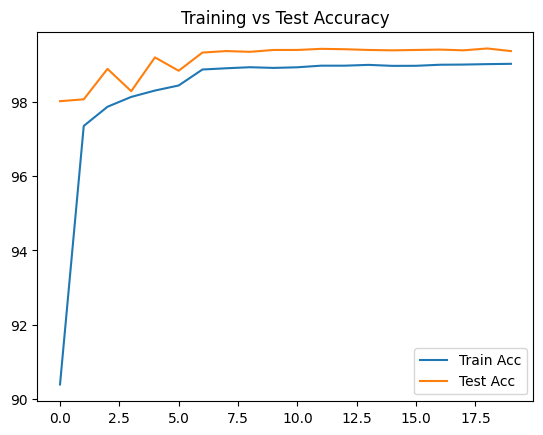

In [ ]:
# -----------------------------
# 7. Plot Results
# -----------------------------
plt.plot(train_acc_list, label='Train Acc')
plt.plot(test_acc_list, label='Test Acc')
plt.legend()
plt.title("Training vs Test Accuracy")
plt.show()

